In [ ]:
# Mount point in google drive, comment it out if runner in other platform
import os
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'SMCD')
drive.mount(MOUNTPOINT)

import sys
sys.path.insert(0,'/content/gdrive/My Drive/SMCD')

# If not using google drive, please uncomment all the above lines but make sure to point DATADIR and have the proper directory structure as mentioned in README

!pip install graphviz
!pip install networkx
!pip install torch-geometric
!pip install torch torchvision
!pip install torch_xla
!pip install transformers

# Only run this if you want TPU
# !pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: uritemplate
    Found existing installation: uritemplate 4.1.1
    Uninstalling uritemplate-4.1.1:
      Successfully uninstalled uritemplate-4.1.1
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.11.1
    Uninstalling google-api-core-2.11.1:
      Successfully uninstalled google-api-core-2.11.1
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.84.0
    Uninstalling google-api-python-client-2.84.0:
      Successfully uninstalled google-api-python-client-2.84.0
ERROR: pip's dependency resolver does not currently take into account all the packages th

In [ ]:
# Mention all the imports
from   collections import defaultdict
import datetime
from   graphviz import Digraph
import matplotlib.pyplot as plt
import networkx as nx
import nltk
from   nltk import ngrams
from   nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
import re
from   sklearn.feature_extraction.text import CountVectorizer
from   sklearn.manifold import TSNE
import seaborn as sns
from   torch_geometric.data import Data, DataLoader
import torch_geometric
from   torch_geometric.nn import GCNConv
from   torch_geometric.utils import to_networkx
import torch
import torch_xla
import torch_xla.core.xla_model as xm
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from   tqdm import tqdm
from   util.get_stock_price import get_open_close_prices
from   util.predict import predict_for_singletext
import warnings

nltk.download('stopwords')
warnings.filterwarnings("ignore", category=FutureWarning)
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Read the csv file
stocks = pd.read_csv(os.path.join(DATADIR, 'dataset', 'stocks_cleaned.csv'))
stockerbot = pd.read_csv(os.path.join(DATADIR, 'dataset', 'stockerbot-export.csv'), error_bad_lines=False)
stockerbot = stockerbot.drop(columns=['id', 'url', 'verified'])

# Casting the columns acrroding to our use
stockerbot["timestamp_alter"] = pd.to_datetime(stockerbot["timestamp"])
stockerbot["text"] = stockerbot["text"].astype(str)
stockerbot["company_names"] = stockerbot["company_names"].astype("category")
stockerbot["symbols"] = stockerbot["symbols"].astype("category")
stockerbot["source"] = stockerbot["source"].astype("category")


# Create separate date & time columns for easier manipulation
stockerbot['date'] = stockerbot['timestamp_alter'].dt.date
stockerbot['time'] = stockerbot['timestamp_alter'].dt.time

# Handeling the missing values
stockerbot.isnull().any()
stockerbot[stockerbot['company_names'].isnull()]

# Get the sentiment of the tweet
def get_message_sentiment(text):
    return predict_for_singletext(text)[1]

#stockerbot['msg_type_logits'] = stockerbot['text'].progress_apply(get_message_sentiment)
stockerbot_msg_logits = pd.read_csv(os.path.join(DATADIR, 'dataset', 'finBERT_predictions.csv'))
stockerbot_open_close_price = pd.read_csv(os.path.join(DATADIR, 'dataset', 'output_data.csv'))

mapping = stockerbot_msg_logits.set_index('sentence')['logitn2sfmx'].to_dict()
stockerbot['msg_type_logits'] = stockerbot['text'].map(mapping)

mapping = stockerbot_open_close_price.set_index(['timestamp', 'source', 'target', 'company'])[['open', 'close']].to_dict()

stockerbot['open_price'] = stockerbot.set_index(['timestamp', 'source', 'symbols', 'company_names']).index.map(mapping['open'])
stockerbot['close_price'] = stockerbot.set_index(['timestamp', 'source', 'symbols', 'company_names']).index.map(mapping['close'])

# Define a function to calculate open and close prices and apply it row-wise
def calculate_open_close_prices(row):
    open, close = get_open_close_prices(row['symbols'], row['timestamp'])
    return pd.Series({'open_price': open, 'close_price': close})

#stockerbot[['open_price', 'close_price']] = stockerbot.progress_apply(calculate_open_close_prices, axis=1)
stockerbot = stockerbot.dropna(subset=['open_price', 'close_price'])
# Reset the index of the DataFrame
stockerbot.reset_index(drop=True, inplace=True)

# Removing links from the tweets
def remove_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    return re.sub(url_pattern, '', text)

stockerbot['text'] = stockerbot['text'].progress_apply(remove_urls)
stockerbot["outcome"] = stockerbot["close_price"] - stockerbot["open_price"]
stockerbot['msg_type_logits'] = stockerbot['msg_type_logits'].str.strip('[]').str.split()
stockerbot['msg_type_logits'] = stockerbot['msg_type_logits'].apply(lambda x: x if isinstance(x, float) else [float(i) for i in x])
# Convert msg_type_logits to numpy array
stockerbot = stockerbot[stockerbot['msg_type_logits'].apply(lambda x: isinstance(x, list) and len(x) == 3)]

msg_type_logits = np.array(stockerbot['msg_type_logits'])
msg_type_logits = [lst if isinstance(lst, list) else [lst] for lst in msg_type_logits]
msg_type_logits = [lst + [None]*(3 - len(lst)) for lst in msg_type_logits]
msg_type_logits = np.array(msg_type_logits)
msg_type_logits
# Determine if the source is smart only based on positive and neagtive
stockerbot['is_smart'] = np.where(msg_type_logits[:, 0] > msg_type_logits[:, 1], stockerbot['outcome'] > 0, stockerbot['outcome'] < 0)

def get_tf_pl(df, col_name):
    total_true, total_false = df[col_name].value_counts()
    # This is based on the is_smart dataset
    print(total_true, total_false)

    profit = df.loc[df[col_name], 'outcome'].abs().sum()
    loss = -1 * df.loc[~df[col_name], 'outcome'].abs().sum()
    print(profit, loss, profit + loss)

# Date wise count of all tweets
#stockerbot['date'].value_counts()

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Check if TPU is available
#if torch_xla._XLAC._xla_get_devices() != []:
#    device = xm.xla_device()

Skipping line 731: expected 8 fields, saw 13
Skipping line 2836: expected 8 fields, saw 15
Skipping line 3058: expected 8 fields, saw 12
Skipping line 3113: expected 8 fields, saw 12
Skipping line 3194: expected 8 fields, saw 17
Skipping line 3205: expected 8 fields, saw 17
Skipping line 3255: expected 8 fields, saw 17
Skipping line 3520: expected 8 fields, saw 17
Skipping line 4078: expected 8 fields, saw 17
Skipping line 4087: expected 8 fields, saw 17
Skipping line 4088: expected 8 fields, saw 17
Skipping line 4499: expected 8 fields, saw 12

100%|██████████| 23176/23176 [00:00<00:00, 259967.88it/s]
<ipython-input-388-229fe596a867>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockerbot['text'] = stockerbot['text'].progress_apply(remove_u

In [ ]:
# Get all the unique source and target nodes
source_nodes = list(set(stockerbot['source'].unique()))
target_nodes = list(set(stockerbot['symbols'].unique()))

nodes = list(set(stockerbot['source'].unique()) | set(stockerbot['symbols'].unique()))

# Create a dictionary for mapping node to index
node_to_index = {node: index for index, node in enumerate(nodes)}

# Count of 'is_smart' for each source
source_counts = stockerbot.groupby('source')['is_smart'].sum()

# Create node_features
node_features = []
for node in nodes:
    source_feature = 1 if node in source_nodes else 0
    target_feature = 1 if node in target_nodes else 0
    node_features.append([source_feature, target_feature])
node_features = torch.tensor(node_features, dtype=torch.float)

# Create edge_index
edge_index = []
for index, row in stockerbot.iterrows():
    source_index = node_to_index[row['source']]
    target_index = node_to_index[row['symbols']]
    edge_index.append([source_index, target_index])
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create edge_features
edge_features = []
for index, row in stockerbot.iterrows():
    msg_type_logits_features = row['msg_type_logits'][:2]
    multiplyer = 1.0 if row['is_smart'] else -1.0
    source_smart = max(1.0, float(source_counts[row['source']]))
    values = row['outcome']
    # Have the absolute value of close - open price for each record
    msg_type_logits_features = np.insert(msg_type_logits_features, 0, abs(values))

    # We multiple it on the basis of if the edge was smart or not
    # It fixes the outcome as well as the logits accrodingly by quantifying them in the correct direction
    msg_type_logits_features = np.multiply(msg_type_logits_features,  multiplyer )

    # Add the multiplyer as this will serve as the classifier for the new predictions
    msg_type_logits_features = np.insert(msg_type_logits_features, 0, multiplyer)
    edge_features.append(msg_type_logits_features)
edge_features = torch.tensor(edge_features, dtype=torch.float)

threshold_class = edge_features[:, 0:1].mean()
threshold_outcome = edge_features[:, 1:2].mean()

# Creating a PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features)
data

Data(x=[5393, 2], edge_index=[2, 23171], edge_attr=[23171, 4])

In [ ]:

torch.manual_seed(28)
np.random.seed(28)

class EdgeFeaturePredictor(nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super(EdgeFeaturePredictor, self).__init__()
        self.node_encoder = GCNConv(num_node_features, 16)
        self.edge_predictor = nn.Linear(32, num_edge_features)
        # Apply Xavier/Glorot initialization to the linear layer
        init.xavier_uniform_(self.edge_predictor.weight)

    def forward(self, data, edge_index):
        x = F.relu(self.node_encoder(data.x, data.edge_index))
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        edge_features = self.edge_predictor(edge_features)

        # Apply tanh to the first value and softmax to the last 2 values
        edge_features = torch.cat([torch.tanh(edge_features[:, :1]), edge_features[:, 1:2], F.softmax(edge_features[:, 2:], dim=1)], dim=1)
        return edge_features

# Instantiate the EdgeFeaturePredictor Model
num_node_features = node_features.size(1)
num_edge_features = edge_features.size(1)
edge_feature_predictor = EdgeFeaturePredictor(num_node_features, num_edge_features).to(device)

# Example training loop
optimizer = torch.optim.Adam(edge_feature_predictor.parameters(), lr=0.0001)

# Run this for less epoch as this has only numnbers and we are converging very quickly
# Running  for more epochs will make the model overfit
for epoch in tqdm(range(1000)):
    edge_feature_predictor.train()
    optimizer.zero_grad()
    predicted_edge_features = edge_feature_predictor(data.to(device), edge_index.to(device))
    loss = nn.MSELoss()(predicted_edge_features, edge_features.to(device))
    #print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    loss.backward()
    optimizer.step()

# Making predictions
edge_feature_predictor.eval()
with torch.no_grad():
    predicted_edge_features = edge_feature_predictor(data.to(device), edge_index.to(device))

#print("Predicted Edge Features:", predicted_edge_features)

# Node classification based on edge features
node_classifications = {i: [] for i in range(1, 8)}

for node in range(node_features.size(0)):
    # Get the edges for the current node
    node_edges = (edge_index[0] == node) | (edge_index[1] == node)

    # Calculate the average of the first value of the edge features
    avg_edge_feature = predicted_edge_features[node_edges, 0].mean()
    avg_edge_outcome = predicted_edge_features[node_edges, 1].mean()

    # Classify the node
    node_classifications[1].append((node, (avg_edge_feature > threshold_class)))  # only classifying on the basis of type of edge
    node_classifications[2].append((node, (avg_edge_outcome > threshold_outcome)))  # only classifying on the basis of type of true outcome
    node_classifications[3].append((node, (avg_edge_feature > threshold_class) & (avg_edge_outcome > threshold_outcome)))  # balanced
    node_classifications[4].append((node, (avg_edge_feature > threshold_class + threshold_class * 0.01) & (avg_edge_outcome > threshold_outcome)))  # more biased towards type of outcome
    node_classifications[5].append((node, (avg_edge_feature > threshold_class) & (avg_edge_outcome > threshold_outcome + threshold_outcome * 0.01)))  # more biased towards total of edge
    node_classifications[6].append((node, (avg_edge_feature > threshold_class - threshold_class * 0.01) & (avg_edge_outcome > threshold_outcome)))  # less biased towards type of edge
    node_classifications[7].append((node, (avg_edge_feature > threshold_class) & (avg_edge_outcome > threshold_outcome - threshold_outcome * 0.01)))  # less biased towards total of outcome

# Convert to long tensor for use with CrossEntropyLoss
for i in range(1, 8):
    node_classifications[i] = [(node, torch.tensor(classification).long().to(device)) for node, classification in node_classifications[i]]

# Check how many edges changed there predictions
cnt = 0
total = 0
gcn_pred = []
for i, j, k in zip(predicted_edge_features, edge_features, stockerbot['outcome']):
    total += 1
    flag = False
    if (i[2] > i[3] and j[2] < j[3]) or (i[2] < i[3] and j[2] > j[3]):
        cnt += 1

    if i[2] > i[3] and k > 0:
        flag = True
    elif i[2] < i[3] and k <= 0:
        flag = True
    gcn_pred.append(flag)

stockerbot['gcn_pred'] = gcn_pred

print(cnt, total)

# get the total correct and incorrect edges
get_tf_pl(stockerbot, 'is_smart')
get_tf_pl(stockerbot, 'gcn_pred')


def analyze_node_classification(node_classification):
    node_classes = ["Non Reliable", "Reliable"]
    count_reliable = 0
    count_non_reliable = 0
    for node, classification in node_classification:
        predict = node_classes[classification]
        if predict == "Reliable":
            count_reliable += 1
        else:
            count_non_reliable += 1

    print(f"Reliable: {count_reliable / (count_reliable + count_non_reliable)}, Non-Reliable: {count_non_reliable / (count_reliable + count_non_reliable)}")

    gnn_r_true, gnn_r_false, gnn_nr_true, gnn_nr_false = 0, 0, 0, 0
    new_profit, new_loss, new_nr_profit, new_nr_loss = 0, 0, 0, 0
    for node, classification in node_classification:
        predict = node_classes[classification]
        if predict == "Reliable":
            gnn_r_true += len(stockerbot[(stockerbot['gcn_pred'] == True) & (stockerbot['source'] == nodes[node])])
            new_profit += stockerbot[stockerbot['source'] == nodes[node]].loc[stockerbot['gcn_pred'], 'outcome'].abs().sum()
            gnn_r_false += len(stockerbot[(stockerbot['gcn_pred'] == False) & (stockerbot['source'] == nodes[node])])
            new_loss += (-1 * stockerbot[stockerbot['source'] == nodes[node]].loc[~stockerbot['gcn_pred'], 'outcome'].abs().sum())
        else:
            gnn_nr_true += len(stockerbot[(stockerbot['gcn_pred'] == True) & (stockerbot['source'] == nodes[node])])
            gnn_nr_false += len(stockerbot[(stockerbot['gcn_pred'] == False) & (stockerbot['source'] == nodes[node])])
            new_nr_profit += stockerbot[stockerbot['source'] == nodes[node]].loc[stockerbot['gcn_pred'], 'outcome'].abs().sum()
            new_nr_loss += (-1 * stockerbot[stockerbot['source'] == nodes[node]].loc[~stockerbot['gcn_pred'], 'outcome'].abs().sum())



    print(f'Our Model:')
    print(f"True Reliable: {gnn_r_true / (gnn_r_true + gnn_r_false)}, False Reliable: {gnn_r_false  / (gnn_r_true + gnn_r_false)}, True Non-Reliable: {gnn_nr_true / (gnn_nr_true + gnn_nr_false)}, False Non-Reliable: {gnn_nr_false /  (gnn_nr_true + gnn_nr_false)}")
    print(f"Profit: {new_profit / (new_profit + new_loss)}, Loss: {new_loss / (new_profit + new_loss)}, Total: {new_profit + new_loss}")
    print(f"Non-Reliable Profit: {new_nr_profit / (new_nr_profit + new_nr_loss)}, Non-Reliable Loss: {new_nr_loss / (new_nr_profit + new_nr_loss)}, Total: {new_nr_profit + new_nr_loss}")


    gnn_r_true, gnn_r_false, gnn_nr_true, gnn_nr_false = 0, 0, 0, 0
    new_profit, new_loss, new_nr_profit, new_nr_loss = 0, 0, 0, 0
    for node, classification in node_classification:
        predict = node_classes[classification]
        if predict == "Reliable":
            gnn_r_true += len(stockerbot[(stockerbot['is_smart'] == True) & (stockerbot['source'] == nodes[node])])
            new_profit += stockerbot[stockerbot['source'] == nodes[node]].loc[stockerbot['is_smart'], 'outcome'].abs().sum()
            gnn_r_false += len(stockerbot[(stockerbot['is_smart'] == False) & (stockerbot['source'] == nodes[node])])
            new_loss += (-1 * stockerbot[stockerbot['source'] == nodes[node]].loc[~stockerbot['is_smart'], 'outcome'].abs().sum())
        else:
            gnn_nr_true += len(stockerbot[(stockerbot['is_smart'] == True) & (stockerbot['source'] == nodes[node])])
            gnn_nr_false += len(stockerbot[(stockerbot['is_smart'] == False) & (stockerbot['source'] == nodes[node])])
            new_nr_profit += stockerbot[stockerbot['source'] == nodes[node]].loc[stockerbot['is_smart'], 'outcome'].abs().sum()
            new_nr_loss += (-1 * stockerbot[stockerbot['source'] == nodes[node]].loc[~stockerbot['is_smart'], 'outcome'].abs().sum())

    print(f'FinBERT')
    print(f"True Reliable: {gnn_r_true / (gnn_r_true + gnn_r_false)}, False Reliable: {gnn_r_false  / (gnn_r_true + gnn_r_false)}, True Non-Reliable: {gnn_nr_true / (gnn_nr_true + gnn_nr_false)}, False Non-Reliable: {gnn_nr_false /  (gnn_nr_true + gnn_nr_false)}")
    print(f"Profit: {new_profit / (new_profit + new_loss)}, Loss: {new_loss / (new_profit + new_loss)}, Total: {new_profit + new_loss}")
    print(f"Non-Reliable Profit: {new_nr_profit / (new_nr_profit + new_nr_loss)}, Non-Reliable Loss: {new_nr_loss / (new_nr_profit + new_nr_loss)}, Total: {new_nr_profit + new_nr_loss}")

# Run analysis for all 7 types
for i in range(1, 8):
    print(f"\nAnalysis for Node Classification Type {i}:")
    analyze_node_classification(node_classifications[i])

100%|██████████| 1000/1000 [00:28<00:00, 35.35it/s]
<ipython-input-412-3d5869a8c120>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_classifications[i] = [(node, torch.tensor(classification).long().to(device)) for node, classification in node_classifications[i]]


11932 23171
11799 11372
10570.196576416496 -11863.685552984474 -1293.4889765679782
11891 11280
13323.75769779086 -9110.124431610113 4213.633266180746

Analysis for Node Classification Type 1:
Reliable: 0.47839792323382163, Non-Reliable: 0.5216020767661784
Our Model:
True Reliable: 0.48889513635085746, False Reliable: 0.5111048636491425, True Non-Reliable: 0.4799480133679911, False Non-Reliable: 0.5200519866320089
Profit: 3.9457570275104112, Loss: -2.9457570275104112, Total: 2234.8853692635885
Non-Reliable Profit: 2.2769161515513, Non-Reliable Loss: -1.2769161515513001, Total: 1978.7478969171634
FinBERT
True Reliable: 0.5069440539780714, False Reliable: 0.4930559460219286, True Non-Reliable: 0.5167099888600074, False Non-Reliable: 0.4832900111399926
Profit: -15.233501579681482, Loss: 16.23350157968148, Total: -489.4569672122607
Non-Reliable Profit: -3.87304616851974, Non-Reliable Loss: 4.87304616851974, Total: -804.0320093557234

Analysis for Node Classification Type 2:
Reliable: 0.8948

In [ ]:
stockerbot_original = stockerbot.copy()
stockerbot_original = stockerbot_original.sort_values(by=['date', 'time'])

# First, ensure that 'date' and 'time' are in the correct datetime format
stockerbot_original['date'] = pd.to_datetime(stockerbot_original['date'])
stockerbot_original['time'] = pd.to_datetime(stockerbot_original['time'], format='%H:%M:%S').dt.time

# Create a combined datetime column for comparison
stockerbot_original['datetime'] = stockerbot_original.apply(lambda row: datetime.datetime.combine(row['date'], row['time']), axis=1)

# Define the cutoff datetime
cutoff_datetime = datetime.datetime(2018, 7, 18, 8, 0, 0)

# Split the DataFrame into two based on the cutoff datetime
before_cutoff = stockerbot_original[stockerbot_original['datetime'] < cutoff_datetime]
after_cutoff = stockerbot_original[stockerbot_original['datetime'] >= cutoff_datetime]

In [ ]:
# Get all the unique source and target nodes
source_nodes = list(set(before_cutoff['source'].unique()))
target_nodes = list(set(before_cutoff['symbols'].unique()))

nodes = list(set(before_cutoff['source'].unique()) | set(before_cutoff['symbols'].unique()))

# Create a dictionary for mapping node to index
node_to_index = {node: index for index, node in enumerate(nodes)}

# Count of 'is_smart' for each source
source_counts = before_cutoff.groupby('source')['is_smart'].sum()

# Create node_features
node_features = []
for node in nodes:
    source_feature = 1 if node in source_nodes else 0
    target_feature = 1 if node in target_nodes else 0
    node_features.append([source_feature, target_feature])
node_features = torch.tensor(node_features, dtype=torch.float)

# Create edge_index
edge_index = []
for index, row in before_cutoff.iterrows():
    source_index = node_to_index[row['source']]
    target_index = node_to_index[row['symbols']]
    edge_index.append([source_index, target_index])
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create edge_features
edge_features = []
for index, row in before_cutoff.iterrows():
    msg_type_logits_features = row['msg_type_logits'][:2]
    multiplyer = 1.0 if row['is_smart'] else -1.0
    source_smart = max(1.0, float(source_counts[row['source']]))
    values = row['outcome']
    # Have the absolute value of close - open price for each record
    msg_type_logits_features = np.insert(msg_type_logits_features, 0, abs(values))

    # We multiple it on the basis of if the edge was smart or not
    # It fixes the outcome as well as the logits accrodingly by quantifying them in the correct direction
    msg_type_logits_features = np.multiply(msg_type_logits_features,  multiplyer )

    # Add the multiplyer as this will serve as the classifier for the new predictions
    msg_type_logits_features = np.insert(msg_type_logits_features, 0, multiplyer)
    edge_features.append(msg_type_logits_features)
edge_features = torch.tensor(edge_features, dtype=torch.float)

threshold_class = edge_features[:, 0:1].mean()
threshold_outcome = edge_features[:, 1:2].mean()

# Creating a PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features)
data

Data(x=[3211, 2], edge_index=[2, 14714], edge_attr=[14714, 4])

In [ ]:
torch.manual_seed(28)
np.random.seed(28)

class EdgeFeaturePredictor(nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super(EdgeFeaturePredictor, self).__init__()
        self.node_encoder = GCNConv(num_node_features, 16)
        self.edge_predictor = nn.Linear(32, num_edge_features)
        # Apply Xavier/Glorot initialization to the linear layer
        init.xavier_uniform_(self.edge_predictor.weight)

    def forward(self, data, edge_index):
        x = F.relu(self.node_encoder(data.x, data.edge_index))
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        edge_features = self.edge_predictor(edge_features)

        # Apply tanh to the first value and softmax to the last 2 values
        edge_features = torch.cat([torch.tanh(edge_features[:, :1]), edge_features[:, 1:2], F.softmax(edge_features[:, 2:], dim=1)], dim=1)
        return edge_features

# Instantiate the EdgeFeaturePredictor Model
num_node_features = node_features.size(1)
num_edge_features = edge_features.size(1)
edge_feature_predictor = EdgeFeaturePredictor(num_node_features, num_edge_features).to(device)

# Example training loop
optimizer = torch.optim.Adam(edge_feature_predictor.parameters(), lr=0.0001)

# Run this for less epoch as this has only numnbers and we are converging very quickly
# Running  for more epochs will make the model overfit
for epoch in tqdm(range(1000)):
    edge_feature_predictor.train()
    optimizer.zero_grad()
    predicted_edge_features = edge_feature_predictor(data.to(device), edge_index.to(device))
    loss = nn.MSELoss()(predicted_edge_features, edge_features.to(device))
    #print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    loss.backward()
    optimizer.step()

# Making predictions
edge_feature_predictor.eval()
with torch.no_grad():
    predicted_edge_features = edge_feature_predictor(data.to(device), edge_index.to(device))

100%|██████████| 1000/1000 [00:17<00:00, 57.47it/s]


In [ ]:
# Convert edge_index to a set for faster lookup
existing_edges = set(zip(edge_index[0].tolist(), edge_index[1].tolist()))

# Initialize lists to hold the new edges
new_source_nodes = []
new_target_nodes = []

# Iterate over all possible edges
for source_name in source_nodes:
    for target_name in target_nodes:
        source = node_to_index[source_name]
        target = node_to_index[target_name]
        # Check if the edge is not in the existing edges
        if (source, target) not in existing_edges:
            new_source_nodes.append(source)
            new_target_nodes.append(target)

# Convert the lists to a tensor
new_edges = torch.tensor([new_source_nodes, new_target_nodes], dtype=torch.long)

# Make predictions for the new edges
edge_feature_predictor.eval()
with torch.no_grad():
    new_predicted_edge_features = edge_feature_predictor(data, new_edges)

In [ ]:
nodes_stockerbot_original = list(set(stockerbot_original['source'].unique()) | set(stockerbot_original['symbols'].unique()))

# Create a dictionary for mapping node to index
node_to_index_stockerbot_original = {node: index for index, node in enumerate(nodes_stockerbot_original)}

node_set = set()
source_set = set(before_cutoff['source'].unique())
target_set = set(before_cutoff['symbols'].unique())

convert_true = 0
convert_false = 0
remain_same = 0

init_neg = 0
init_pos = 0

gcn_neg = 0
gcn_pos = 0

f1, f2, g1,g2 =0,0,0,0

for index, row in after_cutoff.iterrows():
    v1 = node_to_index_stockerbot_original[row['source']]
    v2 = node_to_index_stockerbot_original[row['symbols']]

    # Find the indices where v1 is in the first row and v2 is in the second row for edge_index
    indices_edge_index = (edge_index[0] == v1) & (edge_index[1] == v2)
    index_edge_index = torch.where(indices_edge_index)[0]

    # Find the indices where v1 is in the first row and v2 is in the second row for new_edges
    indices_new_edges = (new_edges[0] == v1) & (new_edges[1] == v2)
    index_new_edges = torch.where(indices_new_edges)[0]


    if len(index_edge_index) == 0 and len(index_new_edges) > 0:
        for ind in index_new_edges:
            if new_predicted_edge_features[ind][0] > threshold_class and new_predicted_edge_features[ind][1] > threshold_outcome:
                pos_log = new_predicted_edge_features[ind][2]
                neg_log = new_predicted_edge_features[ind][3]
                value = row['outcome']

                gnc_pred_flag = False
                if pos_log > neg_log:
                    if value > 0:
                        gnc_pred_flag = True
                else:
                    if value <= 0:
                        gnc_pred_flag = True

                if row['is_smart'] != gnc_pred_flag:
                    if row['is_smart'] == True:
                        convert_false += 1
                    else:
                        convert_true += 1

                else:
                  remain_same += 1

                if row['is_smart'] == False:
                    init_neg +=1
                    f1 += abs(value)
                else:
                    init_pos += 1
                    f2 += abs(value)

                if gnc_pred_flag == False:
                    gcn_neg += 1
                    g1 += abs(value)
                else:
                    gcn_pos += 1
                    g2 += abs(value)

print(convert_true, convert_false, remain_same)
print(init_pos, init_neg, gcn_pos, gcn_neg)
print((f2 - f1) / (f1 + f2), f1, (g2 - g1) / (g2 + g1), g1)

7 6 25
21 17 22 16
0.025013399670423934 9.549968719482415 0.4109235184297206 5.769989013671857


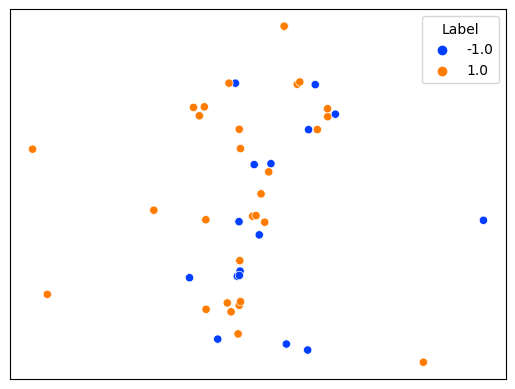

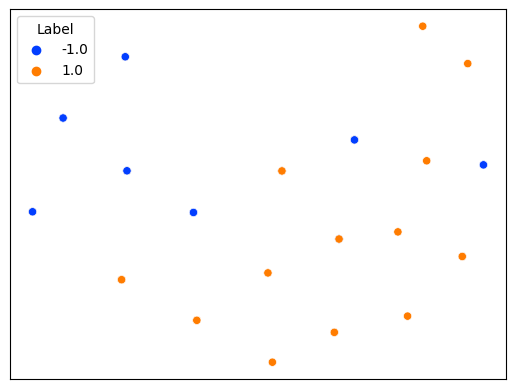

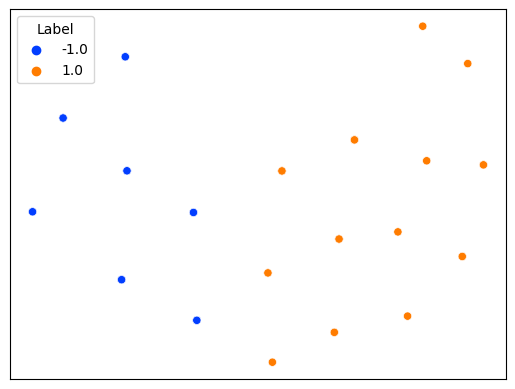

In [ ]:
def tsne_plot(labels, edge_features_plot, x_label):
    # Convert the list of tensors to a list of lists
    data_list = [tensor.tolist() for tensor in edge_features_plot]

    # Define column names
    column_names = ["Column_1", "Column_2", "Column_3", "Column_4"]

    # Create a DataFrame
    df = pd.DataFrame(data_list, columns=column_names)

    # Dataframe without the label column
    df_without_label = df.drop(["Column_1"], axis=1)
    data = df_without_label

    # Fitting TSNE
    model = TSNE(n_components = 2, random_state = 42)
    tsne_data = model.fit_transform(df_without_label)

    # Creating a new data frame which helps us in plotting the result data
    tsne_data = np.vstack((tsne_data.T, labels.T)).T
    tsne_df = pd.DataFrame(data = tsne_data, columns =("Dim_1", "Dim_2", "Label"))

    # Plotting the result of t-SNE
    sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
                    hue='Label', palette="bright")

    # Hide y label
    plt.ylabel('')
    plt.xlabel('')

    # Hide values along both axes
    plt.xticks([])
    plt.yticks([])

    plt.show()

# Create labels dataframe of is_smart values for plotting
labels = []
for itr, row in stockerbot.iterrows():
    multiplyer = 1.0 if row['is_smart'] else -1.0
    labels.append(multiplyer)

labels = torch.tensor(labels, dtype=torch.float)
labels = pd.DataFrame(labels, columns = ['Label'])
labels1 = labels.head(50)
edge_features1 = edge_features[:50]
edge_features1[:, 1:] = edge_features1[:, 1:] * edge_features1[:, 0:1]
tsne_plot(labels1, edge_features1, 'before training (finbert predictions)')
predicted_edge_features1 = predicted_edge_features[:50]
pred_labels = predicted_edge_features1[:, 0:1]
binary_values = np.where(pred_labels > threshold_class, 1, -1)
predicted_edge_features2 = torch.tensor(np.reshape(binary_values, (-1, 1)), dtype=torch.float)
tsne_plot(labels1, predicted_edge_features1, "after training (finbert predictions)")
tsne_plot(predicted_edge_features2, predicted_edge_features1, "after training (our predictions)")

In [ ]:
# Convert edge_index to a set for faster lookup
existing_edges = set(zip(edge_index[0].tolist(), edge_index[1].tolist()))

# Initialize lists to hold the new edges
new_source_nodes = []
new_target_nodes = []

# Iterate over all possible edges
for source_name in source_nodes:
    for target_name in target_nodes:
        source = node_to_index[source_name]
        target = node_to_index[target_name]
        # Check if the edge is not in the existing edges
        if (source, target) not in existing_edges:
            new_source_nodes.append(source)
            new_target_nodes.append(target)

# Convert the lists to a tensor
new_edges = torch.tensor([new_source_nodes, new_target_nodes], dtype=torch.long)

# Make predictions for the new edges
edge_feature_predictor.eval()
with torch.no_grad():
    new_predicted_edge_features = edge_feature_predictor(data, new_edges)

# Print the predicted edge features for the new edges
print("Predicted Edge Features for New Edges:")
print(new_predicted_edge_features)
print(len(new_predicted_edge_features))

Predicted Edge Features for New Edges:
tensor([[-0.0351,  0.3820,  0.5066,  0.4934],
        [-0.0127,  0.3954,  0.5052,  0.4948],
        [ 0.0581,  0.4379,  0.5007,  0.4993],
        ...,
        [ 0.0368,  0.4250,  0.5020,  0.4980],
        [-0.0850,  0.3523,  0.5098,  0.4902],
        [ 0.0658,  0.4425,  0.5002,  0.4998]])
1810894


In [ ]:

# Create a new directed graph
dot = Digraph()

# Convert node_classification to a dictionary
node_classification_dict = dict(node_classification)

# Add nodes to the graph
node_colors = []
for node in range(node_features.size(0)):
    if node_features[node].tolist() in [[1, 0], [1, 1]]:
        # Check the node_classification_dict
        node_colors.append('green' if node_classification_dict.get(node, 0) else 'red')
    else:
        node_colors.append('grey')
    dot.node(str(node), color=node_colors[node], style='filled')

# Add old edges to the graph and store edge weights
old_edge_weights = defaultdict(list)
for i in range(edge_index.size(1)):
    node1 = edge_index[0, i].item()
    node2 = edge_index[1, i].item()
    weight = 1 - max(predicted_edge_features[i, 1:].tolist())
    old_edge_weights[(str(node1), str(node2))].append(weight)

# Add new edges to the graph and store edge weights
new_edge_weights = defaultdict(list)
for i in range(new_edges.size(1)):
    node1 = new_edges[0, i].item()
    node2 = new_edges[1, i].item()
    weight = 1 - max(new_predicted_edge_features[i, 1:].tolist())
    new_edge_weights[(str(node1), str(node2))].append(weight)

# Calculate average weights for overlapping old edges and add them to the graph
for edge, weights in old_edge_weights.items():
    avg_weight = round(sum(weights) / len(weights), 2)
    dot.edge(edge[0], edge[1], label=str(avg_weight), color='black')

# Calculate average weights for overlapping new edges and add them to the graph
for edge, weights in new_edge_weights.items():
    avg_weight = round(sum(weights) / len(weights), 2)
    dot.edge(edge[0], edge[1], label=str(avg_weight), color='blue', style='dashed')

# Render the graph
dot.render('graph.png', view=True)
